In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # Useful for chaining steps, but not strictly required for CT alone
import joblib # To save the fitted preprocessor

# Define the path to your extracted features CSV
extracted_features_path = 'extracted_features.csv'

# Load the data into a Pandas DataFrame
try:
    df = pd.read_csv(extracted_features_path)
    print(f"Successfully loaded {len(df)} rows from {extracted_features_path}")
    print("\nInitial DataFrame Head:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()
except FileNotFoundError:
    print(f"Error: The file '{extracted_features_path}' was not found.")
    print("Please ensure your pcap_parser.py ran successfully and the CSV exists.")
    # You might want to remove this exit() if running interactively and troubleshooting
    # However, for a script, it's good to stop if the input is missing.
    # raise FileNotFoundError(f"Missing input file: {extracted_features_path}")
    exit()

Successfully loaded 38 rows from extracted_features.csv

Initial DataFrame Head:
      timestamp          src_ip          dst_ip  protocol  src_port  dst_port  \
0  1.112172e+09   192.168.170.8  192.168.170.20        17     32795        53   
1  1.112172e+09  192.168.170.20   192.168.170.8        17        53     32795   
2  1.112172e+09   192.168.170.8  192.168.170.20        17     32795        53   
3  1.112172e+09  192.168.170.20   192.168.170.8        17        53     32795   
4  1.112172e+09   192.168.170.8  192.168.170.20        17     32795        53   

   packet_length  
0             70  
1             98  
2             70  
3            298  
4             70  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      38 non-null     float64
 1   src_ip         38 non-null     object 
 2   dst_ip         38 

In [2]:
print("\nMissing values before cleaning/processing:")
print(df.isnull().sum())

# Convert 'timestamp' to datetime objects
# Assuming Unix timestamp in seconds; adjust 'unit' if needed (e.g., 'ms' for milliseconds)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
print("\nDataFrame Head after timestamp conversion:")
print(df.head())

# Fill NaN values in 'src_port' and 'dst_port' (e.g., for ICMP traffic which has no ports)
# We fill with -1 as a numerical placeholder, then convert to string for categorical encoding later
df['src_port'] = df['src_port'].fillna(-1).astype(int)
df['dst_port'] = df['dst_port'].fillna(-1).astype(int)
print("\nMissing values after initial port NaN handling:")
print(df.isnull().sum())


Missing values before cleaning/processing:
timestamp        0
src_ip           0
dst_ip           0
protocol         0
src_port         0
dst_port         0
packet_length    0
dtype: int64

DataFrame Head after timestamp conversion:
                      timestamp          src_ip          dst_ip  protocol  \
0 2005-03-30 08:47:46.496046066   192.168.170.8  192.168.170.20        17   
1 2005-03-30 08:47:46.496576071  192.168.170.20   192.168.170.8        17   
2 2005-03-30 08:47:50.501267910   192.168.170.8  192.168.170.20        17   
3 2005-03-30 08:47:51.333400965  192.168.170.20   192.168.170.8        17   
4 2005-03-30 08:47:59.313230991   192.168.170.8  192.168.170.20        17   

   src_port  dst_port  packet_length  
0     32795        53             70  
1        53     32795             98  
2     32795        53             70  
3        53     32795            298  
4     32795        53             70  

Missing values after initial port NaN handling:
timestamp        0
s

In [3]:
# Basic Time-Based Features (from 'timestamp'):
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek # Monday=0, Sunday=6
# df['minute_of_hour'] = df['timestamp'].dt.minute # Uncomment if needed for finer granularity

# Port Presence Indicator: Create binary features for common ports.
# Define some common ports of interest (expand this list based on your needs)
common_ports = {
    'port_21_ftp': 21,
    'port_22_ssh': 22,
    'port_23_telnet': 23,
    'port_80_http': 80,
    'port_443_https': 443,
    'port_3389_rdp': 3389,
    'port_8080_proxy': 8080
}

for feature_name, port_num in common_ports.items():
    df[feature_name] = ((df['src_port'] == port_num) | (df['dst_port'] == port_num)).astype(int)

print("\nDataFrame Head after Time-Based and Port Presence Features:")
print(df.head())


DataFrame Head after Time-Based and Port Presence Features:
                      timestamp          src_ip          dst_ip  protocol  \
0 2005-03-30 08:47:46.496046066   192.168.170.8  192.168.170.20        17   
1 2005-03-30 08:47:46.496576071  192.168.170.20   192.168.170.8        17   
2 2005-03-30 08:47:50.501267910   192.168.170.8  192.168.170.20        17   
3 2005-03-30 08:47:51.333400965  192.168.170.20   192.168.170.8        17   
4 2005-03-30 08:47:59.313230991   192.168.170.8  192.168.170.20        17   

   src_port  dst_port  packet_length  hour_of_day  day_of_week  port_21_ftp  \
0     32795        53             70            8            2            0   
1        53     32795             98            8            2            0   
2     32795        53             70            8            2            0   
3        53     32795            298            8            2            0   
4     32795        53             70            8            2            0   

 

In [4]:
# Convert protocol number to common name for better readability
# This map handles common IP protocols (6: TCP, 17: UDP, 1: ICMP)
protocol_map = {1: 'ICMP', 6: 'TCP', 17: 'UDP'}
df['protocol_name'] = df['protocol'].map(protocol_map).fillna(df['protocol']).astype(str)

# Create a 'normalized' flow key for bidirectional flows
# This sorts source/destination IPs and ports to treat A<->B traffic as one flow
df['sorted_ips'] = df.apply(lambda row: tuple(sorted([row['src_ip'], row['dst_ip']])), axis=1)
df['sorted_ports'] = df.apply(lambda row: tuple(sorted([row['src_port'], row['dst_port']])), axis=1)

df['bidirectional_flow_key'] = df.apply(lambda row:
    f"{row['sorted_ips'][0]}_{row['sorted_ips'][1]}_{row['sorted_ports'][0]}_{row['sorted_ports'][1]}_{row['protocol_name']}", axis=1)

# Calculate flow-based features by grouping on the bidirectional flow key
bidirectional_flow_features = df.groupby('bidirectional_flow_key').agg(
    bidir_flow_duration=('timestamp', lambda x: (x.max() - x.min()).total_seconds()),
    bidir_total_packets=('packet_length', 'size'),
    bidir_total_bytes=('packet_length', 'sum'),
    bidir_mean_packet_length=('packet_length', 'mean'),
    bidir_std_packet_length=('packet_length', 'std'),
    num_unique_src_ips=('src_ip', lambda x: x.nunique()),
    num_unique_dst_ips=('dst_ip', lambda x: x.nunique())
).reset_index()

# Handle single-packet flows where duration/std_packet_length would be NaN/0
# Replace 0 duration for single packets with NaN (to represent 'not applicable' or very short flow)
# Replace NaN std_packet_length (for single packet flows) with 0
bidirectional_flow_features['bidir_flow_duration'] = bidirectional_flow_features['bidir_flow_duration'].replace(0, np.nan).fillna(0)
bidirectional_flow_features['bidir_std_packet_length'] = bidirectional_flow_features['bidir_std_packet_length'].fillna(0)


# Merge these bidirectional flow features back to the original packet DataFrame
df = pd.merge(df, bidirectional_flow_features, on='bidirectional_flow_key', how='left')

print("\nDataFrame Head after merging Bidirectional Flow Features:")
print(df.head())
print("\nDataFrame Info after merging Bidirectional Flow Features:")
df.info()


DataFrame Head after merging Bidirectional Flow Features:
                      timestamp          src_ip          dst_ip  protocol  \
0 2005-03-30 08:47:46.496046066   192.168.170.8  192.168.170.20        17   
1 2005-03-30 08:47:46.496576071  192.168.170.20   192.168.170.8        17   
2 2005-03-30 08:47:50.501267910   192.168.170.8  192.168.170.20        17   
3 2005-03-30 08:47:51.333400965  192.168.170.20   192.168.170.8        17   
4 2005-03-30 08:47:59.313230991   192.168.170.8  192.168.170.20        17   

   src_port  dst_port  packet_length  hour_of_day  day_of_week  port_21_ftp  \
0     32795        53             70            8            2            0   
1        53     32795             98            8            2            0   
2     32795        53             70            8            2            0   
3        53     32795            298            8            2            0   
4     32795        53             70            8            2            0   

   

In [5]:
# Identify features to drop (original raw IDs, temporary keys)
features_to_drop_for_preprocessing = [
    'timestamp',           # Original timestamp
    'src_ip',              # Original source IP (will be captured in flow features, or can be included directly if needed)
    'dst_ip',              # Original destination IP (same as above)
    'flow_key',            # Temporary flow key (if you created one before bidirectional)
    'bidirectional_flow_key', # The key used for merging, not a feature itself
    'sorted_ips',          # Temporary sorted IPs
    'sorted_ports',        # Temporary sorted ports
    'protocol'             # Original protocol number (we use 'protocol_name' now)
]

# Drop these columns to prepare df for the ColumnTransformer
# Using .copy() to avoid SettingWithCopyWarning later
df_processed = df.drop(columns=features_to_drop_for_preprocessing, errors='ignore').copy()

# Ensure ports are string type before categorizing for OneHotEncoder
df_processed['src_port'] = df_processed['src_port'].astype(str)
df_processed['dst_port'] = df_processed['dst_port'].astype(str)

# Define column types for the ColumnTransformer
# Numerical columns: These will be scaled.
# Includes original packet features, derived time features, derived flow features, and binary port indicators.
numerical_cols = [
    'packet_length',
    'hour_of_day',
    'day_of_week',
    'minute_of_hour', # Uncomment if you used it
    'bidir_flow_duration',
    'bidir_total_packets',
    'bidir_total_bytes',
    'bidir_mean_packet_length',
    'bidir_std_packet_length',
    'num_unique_src_ips',
    'num_unique_dst_ips',
    # Add the binary port features
    'port_21_ftp', 'port_22_ssh', 'port_23_telnet', 'port_80_http',
    'port_443_https', 'port_3389_rdp', 'port_8080_proxy'
]

# Categorical columns: These will be one-hot encoded.
# 'src_port' and 'dst_port' are treated as categorical here (after filling NaNs and converting to string)
categorical_cols = ['protocol_name', 'src_port', 'dst_port']

# Ensure all numerical columns are numeric and fill any remaining NaNs with 0
# This is a robust way to handle potential NaNs introduced during feature engineering (e.g., from std_packet_length for single-packet flows)
for col in numerical_cols:
    if col in df_processed.columns: # Check if column actually exists in the DataFrame
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce').fillna(0)
    else:
        # If a column expected to be numerical is missing, it might be an issue.
        # For small specific PCAPs, some features might always be 0/missing.
        # You might choose to add a column of zeros if it's missing entirely.
        print(f"Warning: Numerical column '{col}' not found in df_processed. Adding as all zeros.")
        df_processed[col] = 0.0


print(f"\nNumerical columns identified for scaling: {numerical_cols}")
print(f"Categorical columns identified for encoding: {categorical_cols}")

# Create the ColumnTransformer
# 'num': Applies StandardScaler to numerical_cols
# 'cat': Applies OneHotEncoder to categorical_cols, handling unknown categories gracefully
# 'remainder='passthrough'': Keeps any columns not explicitly listed in transformers.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # If there are any other columns not in numerical/categorical_cols, they'll pass through
)

# Fit the preprocessor to the data and then transform it
# preprocessor.fit_transform(df_processed) does two things:
# 1. 'fit': Learns the mean and std for StandardScaler, and learns all unique categories for OneHotEncoder.
# 2. 'transform': Applies these learned transformations to the data.
print("\nApplying preprocessing (scaling and encoding) with ColumnTransformer...")
X_preprocessed = preprocessor.fit_transform(df_processed)
print("Preprocessing complete.")

# Get the names of ALL output columns from the preprocessor
# This is the robust way to get column names for the transformed data
all_preprocessed_cols = preprocessor.get_feature_names_out()

# Convert the preprocessed NumPy array back to a Pandas DataFrame for easier handling
df_final_preprocessed = pd.DataFrame(X_preprocessed, columns=all_preprocessed_cols)

print("\nFinal Preprocessed DataFrame Head:")
print(df_final_preprocessed.head())
print("\nFinal Preprocessed DataFrame Info:")
df_final_preprocessed.info()
print(f"\nShape of final preprocessed data: {df_final_preprocessed.shape}")


Numerical columns identified for scaling: ['packet_length', 'hour_of_day', 'day_of_week', 'minute_of_hour', 'bidir_flow_duration', 'bidir_total_packets', 'bidir_total_bytes', 'bidir_mean_packet_length', 'bidir_std_packet_length', 'num_unique_src_ips', 'num_unique_dst_ips', 'port_21_ftp', 'port_22_ssh', 'port_23_telnet', 'port_80_http', 'port_443_https', 'port_3389_rdp', 'port_8080_proxy']
Categorical columns identified for encoding: ['protocol_name', 'src_port', 'dst_port']

Applying preprocessing (scaling and encoding) with ColumnTransformer...
Preprocessing complete.

Final Preprocessed DataFrame Head:
   num__packet_length  num__hour_of_day  num__day_of_week  \
0           -0.677762               0.0               0.0   
1            0.011663               0.0               0.0   
2           -0.677762               0.0               0.0   
3            4.936129               0.0               0.0   
4           -0.677762               0.0               0.0   

   num__minute_of_ho

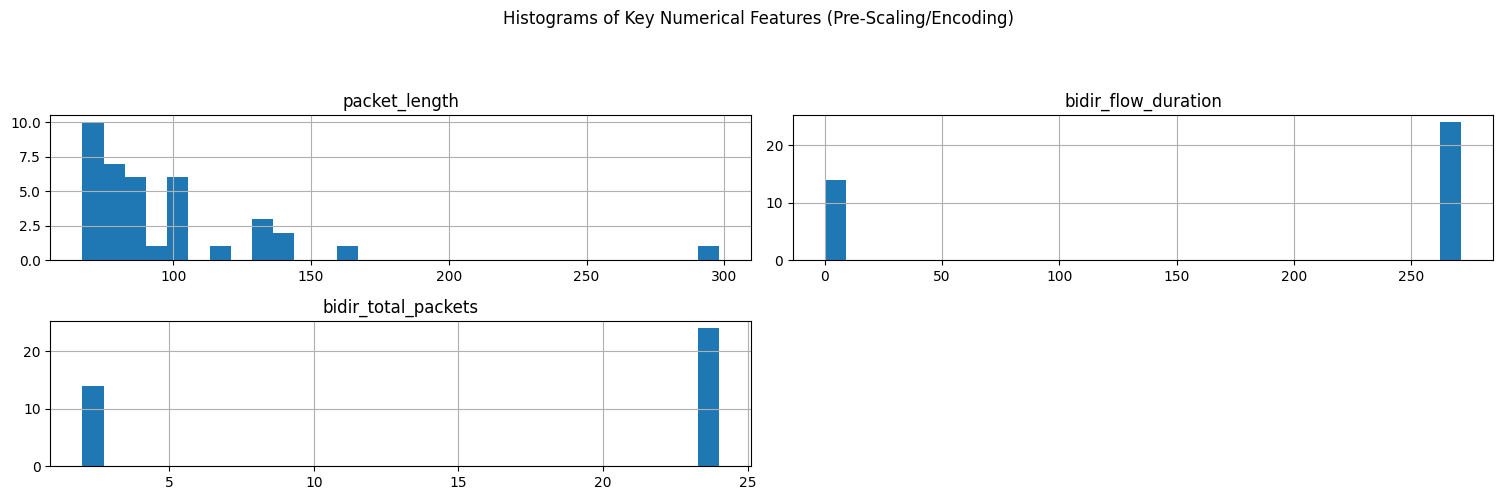

Not enough numerical features in final DataFrame for correlation matrix.


<Figure size 1400x1200 with 0 Axes>

In [6]:
# Select a few key numerical features to visualize (from the original pre-scaled data)
# You can pick some from 'numerical_cols' that you defined
features_to_hist = ['packet_length', 'bidir_flow_duration', 'bidir_total_packets'] # Using original feature names from df_processed
# Ensure these exist in df_processed before plotting
existing_features_for_hist = [f for f in features_to_hist if f in df_processed.columns]

if existing_features_for_hist:
    df_processed[existing_features_for_hist].hist(bins=30, figsize=(15, 5))
    plt.suptitle("Histograms of Key Numerical Features (Pre-Scaling/Encoding)", y=1.02) # Adjust suptitle position
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show()
else:
    print("No numerical features found for histogram plotting.")

# Correlation Matrix (for numerical features) - use the scaled numerical data for this after transform
# Or use the original df_processed numerical columns before scaling if you want to see raw correlations
plt.figure(figsize=(14, 12))
# Only include numerical columns that actually made it into the preprocessed data
numerical_features_in_final = [col for col in numerical_cols if col in df_final_preprocessed.columns]
if numerical_features_in_final:
    sns.heatmap(df_final_preprocessed[numerical_features_in_final].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title("Correlation Matrix of Scaled Numerical Features in Final DataFrame")
    plt.show()
else:
    print("Not enough numerical features in final DataFrame for correlation matrix.")

In [7]:
output_preprocessed_path = 'preprocessed_data.csv'
df_final_preprocessed.to_csv(output_preprocessed_path, index=False)
print(f"\nFinal preprocessed data saved to {output_preprocessed_path}")

# Save the fitted preprocessor
preprocessor_save_path = 'fitted_preprocessor.joblib'
joblib.dump(preprocessor, preprocessor_save_path)
print(f"Fitted preprocessor saved to {preprocessor_save_path}")


Final preprocessed data saved to preprocessed_data.csv
Fitted preprocessor saved to fitted_preprocessor.joblib
